In [1]:
import timeit
import math
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import jet
from skimage.color import label2rgb
from cuda_slic import slic
from sklearn.model_selection import ParameterGrid
from matplotlib import cm
from collections import OrderedDict

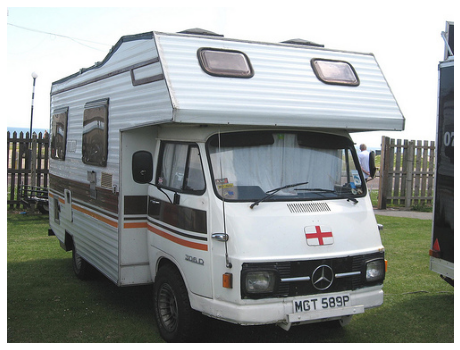

In [17]:
img_path = 'resources/ILSVRC2012_val_00000014.JPEG'
img = cv2.imread(img_path)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
plt.axis('off');
img = cv2.GaussianBlur(img, (7, 7), 1)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, 1:]

## Speedtest iterations

In [ ]:
img_lab = np.zeros((500, 500, 3))
for max_iter in [5, 10, 15, 20]:
    def cuda_slic():
        labels = slic(img_lab, n_segments=100, compactness=5, max_iter=max_iter, convert2lab=False,
                      enforce_connectivity=False)
        return labels


    print(timeit.timeit('cuda_slic()', globals=locals(), number=300) / 300)


In [18]:
def cuda_slic(img_lab, n_segments, compactness, max_iter=3):
    labels = slic(img_lab, n_segments=n_segments, compactness=compactness, max_iter=max_iter, convert2lab=False,
                  enforce_connectivity=False)
    npix = np.max(labels)

    from matplotlib import cm
    c_dict = cm.get_cmap('jet')._segmentdata
    jet_cm = LinearSegmentedColormap('bla', segmentdata=c_dict, N=npix)
    colors = cm.get_cmap(jet_cm, npix)(np.arange(npix))
    np.random.shuffle(colors)

    L = label2rgb(labels, colors=colors, bg_label=-1)
    return L

In [19]:
options_segments = [50, 100, 200, 500]
options_compactness = [5, 7.5, 10, 30]
options_iter = [5, 10]
param_grid = ParameterGrid({'n_segments': options_segments,
                            'compactness': options_compactness})

In [20]:
def eval_image(img, param_grid):
    results = {}
    for params in param_grid:
        results[f'segments: {params["n_segments"]} m: {params["compactness"]}'] = \
            cuda_slic(img, n_segments=params['n_segments'], compactness=params['compactness'])
    return results

In [21]:
image_results = eval_image(img, param_grid)
#print(image_results['segments: 100 m: 2.5'])

In [22]:
def plot_results(results):
    cols = 2
    rows = math.ceil(len(results)/cols)
    fig, ax = plt.subplots(rows, cols, figsize=(15, rows*6))
    for i, (title, res) in enumerate(sorted(results.items(), key=lambda kv: kv[0])):
        ax[i // 2, i % cols].imshow(res)
        ax[i // 2, i % cols].set_title(title)
        ax[i // 2, i % cols].axis('off');

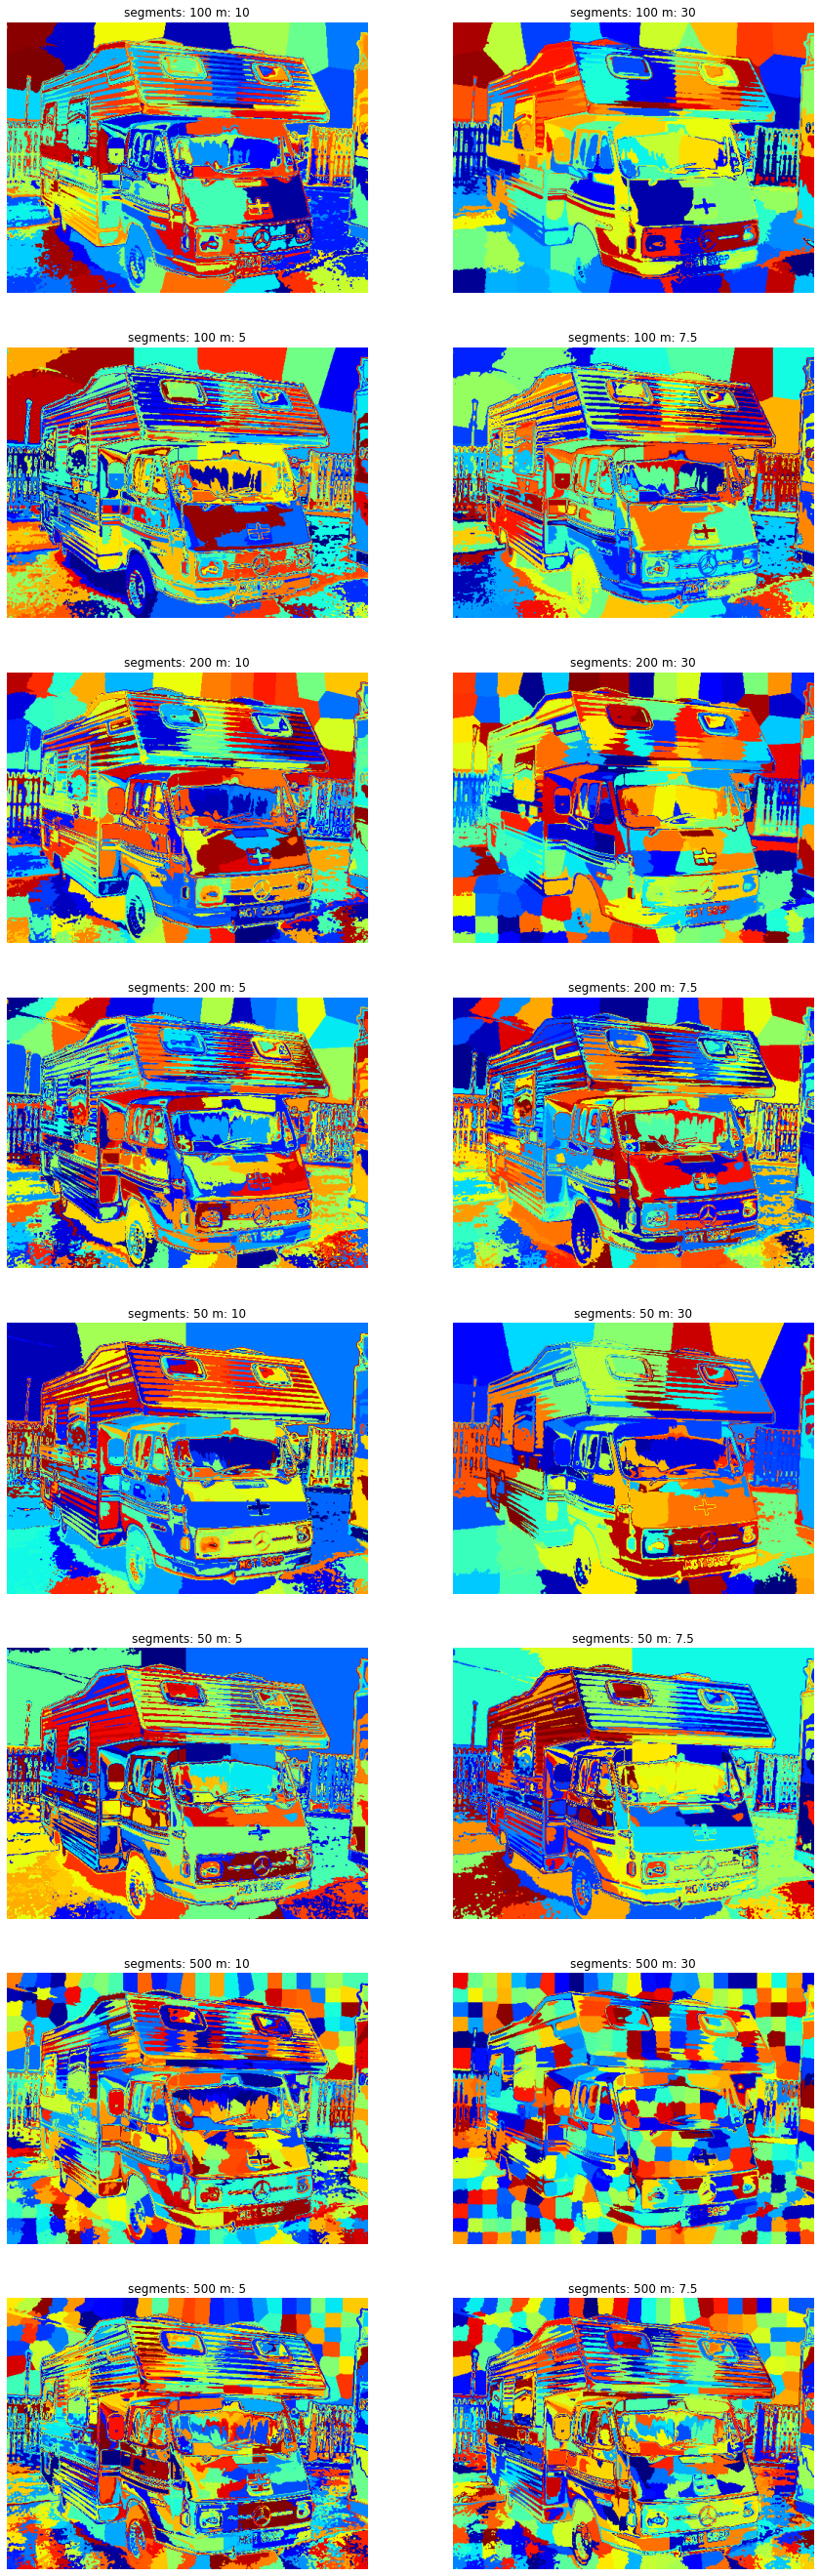

In [23]:
plot_results(image_results)

In [9]:
labels = slic(img_lab, n_segments=100, compactness=5, max_iter=10, convert2lab=False,
                      enforce_connectivity=False)
labels

array([[ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  23,  10,  10],
       ...,
       [ 97,  97,  97, ..., 108, 108, 107],
       [ 85,  85,  97, ..., 108, 108, 107],
       [ 85,  85,  85, ..., 108, 108, 108]])

In [10]:
cv2.imwrite('resources/test.png', labels)

True

In [11]:
np.save('resources/test.npy', labels)

In [12]:
res = cv2.imread('resources/test.png')[:, :, 0]
res

array([[ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  23,  10,  10],
       ...,
       [ 97,  97,  97, ..., 108, 108, 107],
       [ 85,  85,  97, ..., 108, 108, 107],
       [ 85,  85,  85, ..., 108, 108, 108]], dtype=uint8)

In [13]:
res.shape

(400, 500)

In [14]:
segment = np.fromfile('resources/test.png', dtype=np.uint8)

In [15]:
segment = cv2.imdecode(segment, cv2.IMREAD_COLOR)[:, :, 0]

In [16]:
segment

array([[ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  10,  10,  10],
       [ 13,  13,  13, ...,  23,  10,  10],
       ...,
       [ 97,  97,  97, ..., 108, 108, 107],
       [ 85,  85,  97, ..., 108, 108, 107],
       [ 85,  85,  85, ..., 108, 108, 108]], dtype=uint8)